In [1]:
import os
import warnings
import datetime
warnings.filterwarnings("ignore")
from functools import lru_cache
from collections import defaultdict


import tqdm
import lightgbm as lgb
import numpy as np
import pandas as pd
pd.options.display.max_columns=100
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import LabelShuffleSplit

%matplotlib inline

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path_to_train = './data/train_set.csv'
path_to_test = './data/test_set.csv'

In [3]:
dt_tr = pd.read_csv(path_to_train)
dt_ts = pd.read_csv(path_to_test)

dt_tr.columns = ['amount', 'atm_address', 'atm_address_lat', 'atm_address_lon', 'city',
       'country', 'currency', 'customer_id', 'home_add_lat', 'home_add_lon',
       'mcc', 'pos_address', 'pos_address_lat', 'pos_address_lon', 'terminal_id',
       'transaction_date', 'work_add_lat', 'work_add_lon']

dt_ts.mcc = dt_ts.mcc.apply(lambda x: str(x).replace(',', '')).astype(int)

In [4]:
dt_ts.shape, dt_tr.shape

((1265470, 14), (1224734, 18))

In [5]:
dt_tr['lat'] = -1
dt_tr['lon'] = -1

dt_ts['lat'] = -1
dt_ts['lon'] = -1

dt_tr['is_atm_coords'] = -1
dt_ts['is_atm_coords'] = -1

dt_tr['lat'][~np.isnan(dt_tr.atm_address_lat)] = dt_tr.atm_address_lat[~np.isnan(dt_tr.atm_address_lat)]
dt_tr['lon'][~np.isnan(dt_tr.atm_address_lon)] = dt_tr.atm_address_lon[~np.isnan(dt_tr.atm_address_lon)]

dt_tr['lat'][~np.isnan(dt_tr.pos_address_lat)] = dt_tr.pos_address_lat[~np.isnan(dt_tr.pos_address_lat)]
dt_tr['lon'][~np.isnan(dt_tr.pos_address_lon)] = dt_tr.pos_address_lon[~np.isnan(dt_tr.pos_address_lon)]

dt_ts['lat'][~np.isnan(dt_ts.atm_address_lat)] = dt_ts.atm_address_lat[~np.isnan(dt_ts.atm_address_lat)]
dt_ts['lon'][~np.isnan(dt_ts.atm_address_lon)] = dt_ts.atm_address_lon[~np.isnan(dt_ts.atm_address_lon)]

dt_ts['lat'][~np.isnan(dt_ts.pos_address_lat)] = dt_ts.pos_address_lat[~np.isnan(dt_ts.pos_address_lat)]
dt_ts['lon'][~np.isnan(dt_ts.pos_address_lon)] = dt_ts.pos_address_lon[~np.isnan(dt_ts.pos_address_lon)]


dt_tr['is_atm_coords'][~np.isnan(dt_tr.pos_address_lat)] = 0
dt_tr['is_atm_coords'][~np.isnan(dt_tr.atm_address_lat)] = 1

dt_ts['is_atm_coords'][~np.isnan(dt_ts.pos_address_lat)] = 0
dt_ts['is_atm_coords'][~np.isnan(dt_ts.atm_address_lat)] = 1

In [6]:
dt_ts.shape, dt_tr.shape

((1265470, 17), (1224734, 21))

In [7]:
is_home = np.sqrt((dt_tr.home_add_lat - dt_tr.lat) ** 2 + (dt_tr.home_add_lon - dt_tr.lon) ** 2) <= 0.021
is_work = np.sqrt((dt_tr.work_add_lat - dt_tr.lat) ** 2 + (dt_tr.work_add_lon - dt_tr.lon) ** 2) <= 0.021

In [8]:
dt_tr['is_home'] = is_home.astype(int)
dt_tr['is_work'] = is_work.astype(int)

dt_ts['is_home'] = np.nan
dt_ts['is_work'] = np.nan

________________

##### Features

In [9]:
dt_tr.city = dt_tr.city.str.lower().str.replace(' ', '').value_counts()
dt_ts.city = dt_ts.city.str.lower().str.replace(' ', '').value_counts()

##### Label encoder (equal to ========= dt.feature.factorize()[0])

In [10]:
%%time
le = {}
tmp = pd.concat((dt_ts, dt_tr))
for col in ['country', 'currency', 'city']:
    print(col)
    le[col] = LabelEncoder()
    le[col].fit(tmp[col].fillna(-1).astype('str'))
    dt_tr[col] = le[col].transform(dt_tr[col].fillna(-1).astype('str'))
    dt_ts[col] = le[col].transform(dt_ts[col].fillna(-1).astype('str'))
    print(len(np.unique(dt_tr[col].factorize()[0])))
    print(len(np.unique(dt_ts[col].factorize()[0])))

country
127
141
currency
61
67
city
1
1
CPU times: user 28.2 s, sys: 837 ms, total: 29 s
Wall time: 29 s


##### City and distance.

In [11]:
%%time

if os.path.exists('data/centres_of_cities_big.csv'):
    centres_of_cities = pd.read_csv('data/centres_of_cities_big.csv')
else:
    centres_of_cities = pd.read_csv('https://gist.githubusercontent.com/nalgeon/'+\
                '5307af065ff0e3bc97927c832fabe26b/raw/056b7ece3b762723c02d3809ef77e2ae92a2bcd0/cities.csv')
    centres_of_cities = centres_of_cities[['Город', 'Широта', 'Долгота', 'Население']]
    centres_of_cities.columns = ['city',  'lat', 'lon', 'city_population']
    centres_of_cities = centres_of_cities.reset_index()
    centres_of_cities.to_csv('data/centres_of_cities_big.csv', index=False)
    
nn = NearestNeighbors(n_neighbors=1, p=2, n_jobs=6)
nn.fit(centres_of_cities[[ 'lat', 'lon']].astype(float).values)

def get_nearest_city(tr, ts):
    """
    Used additional data  - coordinates of cities centers.
    """
    tr_data = tr.copy().fillna(-1)
    ts_data = ts.copy().fillna(-1)
    cols = ['lat', 'lon']
    
    dt = pd.concat([tr_data[cols], ts_data[cols]], axis=0)
    a = nn.kneighbors(dt[cols].values)[1].flatten()
    dist = nn.kneighbors(dt[cols].values)[0].flatten()
    b, c = np.unique(a, return_counts=True)
    maper = {k:v for k,v in zip(b, c)}
    a = list(map(lambda x: maper[x], a))
    tr_data['city_count_enc'] = a[:tr_data.shape[0]]
    ts_data['city_count_enc'] = a[-ts_data.shape[0]:]
    tr_data['city_dist'] = dist[:tr_data.shape[0]]
    ts_data['city_dist'] = dist[-ts_data.shape[0]:]
    return tr_data, ts_data

dt_tr, dt_ts = get_nearest_city(dt_tr, dt_ts)

CPU times: user 1min 29s, sys: 748 ms, total: 1min 30s
Wall time: 20.1 s


##### terminal counter

In [12]:
%%time

# сколько раз встречался терминал
tmp = pd.concat((dt_tr['terminal_id'], dt_ts['terminal_id'])).value_counts().rename('terminal_id_counter').reset_index()
tmp.columns = ['terminal_id', 'terminal_id_counter']

dt_tr = pd.merge(tmp, dt_tr, on='terminal_id')
dt_ts = pd.merge(tmp, dt_ts, on='terminal_id')

### В скольких городах был терминал
tmp = pd.concat((dt_tr, dt_ts), ignore_index=True).groupby('terminal_id').city.nunique().rename('count_cities_inside_terminal').reset_index()

dt_tr = pd.merge(dt_tr, tmp, on='terminal_id', how='left')
dt_ts = pd.merge(dt_ts, tmp, on='terminal_id', how='left')

CPU times: user 12.1 s, sys: 2.4 s, total: 14.5 s
Wall time: 14.5 s


##### clusterisation

In [13]:
dt_tr.shape

(1224734, 27)

In [14]:
%%time

start = datetime.datetime.now()

for eps in [0.001, 0.005, 0.01, 0.015, 0.02, 0.023, 0.1]:
    feat_name = 'cluster_{}'.format(eps)
    feat_name_counter_encoding = 'cluster_without_duplicates_counter_{}'.format(eps)
    feat_name_counter_encoding_dupl = 'cluster_with_duplicates_counter_{}'.format(eps)
    
    
    tmp = pd.concat((dt_tr[['lon', 'lat']], dt_ts[['lon', 'lat']]), ignore_index=False)
    tmp = tmp[~tmp.duplicated()]

    db = DBSCAN(eps=eps, min_samples=1)
    clstrs = db.fit_predict(tmp.values)
    
    tmp[feat_name] = clstrs
    tmp = pd.merge(tmp, tmp[feat_name].value_counts().rename(feat_name_counter_encoding).reset_index(), 
               how='left', left_on=feat_name, right_on='index').drop(['index'], axis=1)
    
    dt_tr = pd.merge(dt_tr, tmp, how='left', on=['lon', 'lat'])
    dt_ts = pd.merge(dt_ts, tmp, how='left', on=['lon', 'lat'])
    
    tmp = pd.concat((dt_tr[[feat_name]], dt_ts[[feat_name]]), ignore_index=False)
    tmp = tmp[feat_name].value_counts().rename(feat_name_counter_encoding_dupl).reset_index()

    dt_tr = pd.merge(dt_tr, tmp, how='left', left_on=feat_name, right_on='index').drop(['index'], axis=1)
    dt_ts = pd.merge(dt_ts, tmp, how='left', left_on=feat_name, right_on='index').drop(['index'], axis=1)

    print (eps, str(datetime.datetime.now() - start)[:11])

0.001 0:00:13.117
0.005 0:00:27.470
0.01 0:00:42.882
0.015 0:00:59.561
0.02 0:01:17.636
0.023 0:01:36.797
0.1 0:02:08.886
CPU times: user 1min 46s, sys: 22.5 s, total: 2min 9s
Wall time: 2min 8s


In [15]:
dt_tr.shape

(1224734, 48)

In [16]:
start = datetime.datetime.now()

for eps in [0.001, 0.005, 0.01, 0.015, 0.02, 0.023, 0.1]:
    for groubys in [['customer_id', 'mcc'], ['customer_id']]:
        grp = groubys
        suff = '_'.join(list(groubys))

        feat_name = 'cluster_{}'.format(eps)
        new_counter_feat_name = 'number_of_unique_' + feat_name + '_'

        tmp = dt_tr.groupby(grp)[feat_name].nunique().rename(new_counter_feat_name+suff).reset_index()
        dt_tr = pd.merge(dt_tr, tmp, on=grp, how='left')

        tmp = dt_ts.groupby(grp)[feat_name].nunique().rename(new_counter_feat_name+suff).reset_index()
        dt_ts = pd.merge(dt_ts, tmp, on=grp, how='left')

        print (eps, ': ', str(datetime.datetime.now() - start)[:11])

0.001 :  0:00:05.892
0.001 :  0:00:12.367
0.005 :  0:00:19.220
0.005 :  0:00:25.627
0.01 :  0:00:32.353
0.01 :  0:00:38.801
0.015 :  0:00:45.514
0.015 :  0:00:52.009
0.02 :  0:00:58.884
0.02 :  0:01:05.529
0.023 :  0:01:12.605
0.023 :  0:01:19.287
0.1 :  0:01:26.452
0.1 :  0:01:33.289


In [17]:
dt_tr.shape

(1224734, 62)

In [19]:
def grouped_in_clusters_coord_dist_features(data, latitude='', longitude='', pref=''):
    """
    """
    dt = data.copy()
    for eps in [0.005, 0.01, 0.02, 0.023]:
        feat_name = 'cluster_{}'.format(eps)
        
        for groupby in [[feat_name], ['customer_id', feat_name]]:
            start = datetime.datetime.now()

            gr = '_'.join(groupby)
            # std lat & lon
            tmp = dt.groupby(groupby)[latitude].std().rename('lat_std'+pref).reset_index()
            dt = pd.merge(dt, tmp, how='left', on=groupby)
            tmp = dt.groupby(groupby)[latitude].std().rename('lon_std'+pref).reset_index()
            dt = pd.merge(dt, tmp, how='left', on=groupby)
            dt.set_value(dt['lat_std'+pref] != dt['lat_std'+pref], 'lat_std'+pref, -1)
            dt.set_value(dt['lon_std'+pref] != dt['lon_std'+pref], 'lon_std'+pref, -1)

            dt[gr+'_dist_std'+pref] = np.sqrt(dt['lat_std'+pref].values ** 2 + dt['lon_std'+pref].values ** 2)
            dt = dt.drop(['lat_std'+pref, 'lon_std'+pref], axis=1)
            print(gr+'_dist_std'+pref)

            # dist to mean
            tmp = dt.groupby(groupby)[latitude].mean().rename('lat_func').reset_index()
            tmp = pd.merge(dt, tmp, how='left', on=groupby)
            dt['dist_to_lat'+pref] = np.abs(tmp[latitude].values - tmp['lat_func'].values)
            tmp = dt.groupby(groupby)[longitude].mean().rename('lon_func').reset_index()
            tmp = pd.merge(dt, tmp, how='left', on=groupby)
            dt['dist_to_lon'+pref] = np.abs(tmp[longitude].values - tmp['lon_func'].values)

            dt[gr+'_dist_to_mean_'+pref] = np.sqrt(dt['dist_to_lat'+pref].values ** 2 +
                                           dt['dist_to_lon'+pref].values ** 2)
            dt = dt.drop(['dist_to_lat'+pref, 'dist_to_lon'+pref], axis=1)
            print(gr+'_dist_to_mean_'+pref)

            # dist to mode
            tmp = dt.groupby(groupby)[latitude].apply(lambda x:x.value_counts().index[0]).rename('lat_func').reset_index()
            tmp = pd.merge(dt, tmp, how='left', on=groupby)
            dt['dist_to_lat'+pref] = np.abs(tmp[latitude].values - tmp['lat_func'].values)
            tmp = dt.groupby(groupby)[longitude].apply(lambda x:x.value_counts().index[0]).rename('lon_func').reset_index()
            tmp = pd.merge(dt, tmp, how='left', on=groupby)
            dt['dist_to_lon'+pref] = np.abs(tmp[longitude].values - tmp['lon_func'].values)

            dt[gr+'_dist_to_mode_'+pref] = np.sqrt(dt['dist_to_lat'+pref].values ** 2 +
                                           dt['dist_to_lon'+pref].values ** 2)
            dt = dt.drop(['dist_to_lat'+pref, 'dist_to_lon'+pref], axis=1)
            print(gr+'_dist_to_mode_'+pref)

            # dist to quantiles
            for q in [0.025, 0.25, 0.5, 0.75, 0.975]:
                tmp = dt.groupby(groupby)[latitude].quantile(q).rename('lat_func').reset_index()
                tmp = pd.merge(dt, tmp, how='left', on=groupby)
                dt['dist_to_lat'+pref] = np.abs(tmp[latitude].values - tmp['lat_func'].values)
                tmp = dt.groupby(groupby)[longitude].quantile(q).rename('lon_func').reset_index()
                tmp = pd.merge(dt, tmp, how='left', on=groupby)
                dt['dist_to_lon'+pref] = np.abs(tmp[longitude].values - tmp['lon_func'].values)

                dt[gr+'_dist_to_quantile_{}_'.format(int(q * 100))+pref] = np.sqrt(dt['dist_to_lat'+pref].values ** 2 +
                                               dt['dist_to_lon'+pref].values ** 2)
                dt = dt.drop(['dist_to_lat'+pref, 'dist_to_lon'+pref], axis=1)
                print(gr+'_dist_to_quantile_{}_'.format(int(q * 100))+pref)

            print (groupby, str(datetime.datetime.now() - start)[:11])
            
    print('added new features')
    print(set(dt.columns) - set(data.columns))
    return dt  

In [20]:
%%time

dt_tr = grouped_in_clusters_coord_dist_features(dt_tr[dt_tr.lat!=-1], latitude='lat', longitude='lon', pref='+')
dt_ts = grouped_in_clusters_coord_dist_features(dt_ts[dt_ts.lat!=-1], latitude='lat', longitude='lon', pref='+')

cluster_0.005_dist_std+
cluster_0.005_dist_to_mean_+
cluster_0.005_dist_to_mode_+
cluster_0.005_dist_to_quantile_2_+
cluster_0.005_dist_to_quantile_25_+
cluster_0.005_dist_to_quantile_50_+
cluster_0.005_dist_to_quantile_75_+
cluster_0.005_dist_to_quantile_97_+
['cluster_0.005'] 0:01:52.748
customer_id_cluster_0.005_dist_std+
customer_id_cluster_0.005_dist_to_mean_+
customer_id_cluster_0.005_dist_to_mode_+
customer_id_cluster_0.005_dist_to_quantile_2_+
customer_id_cluster_0.005_dist_to_quantile_25_+
customer_id_cluster_0.005_dist_to_quantile_50_+
customer_id_cluster_0.005_dist_to_quantile_75_+
customer_id_cluster_0.005_dist_to_quantile_97_+
['customer_id', 'cluster_0.005'] 0:09:43.942
cluster_0.01_dist_std+
cluster_0.01_dist_to_mean_+
cluster_0.01_dist_to_mode_+
cluster_0.01_dist_to_quantile_2_+
cluster_0.01_dist_to_quantile_25_+
cluster_0.01_dist_to_quantile_50_+
cluster_0.01_dist_to_quantile_75_+
cluster_0.01_dist_to_quantile_97_+
['cluster_0.01'] 0:01:40.360
customer_id_cluster_0.01_

In [21]:
dt_tr.shape

(1127294, 126)

##### how many trans customer did in this day

насколько активен в этот день

In [22]:
%%time
grp = ['customer_id', 'transaction_date']
suff = '_'.join(grp)

tmp = dt_tr.groupby(grp)['amount'].count().rename('count_of_transactions_in_day_for_'+suff).reset_index()
dt_tr = pd.merge(dt_tr, tmp, on=grp, how='left')

tmp = dt_ts.groupby(grp)['amount'].count().rename('count_of_transactions_in_day_for_'+suff).reset_index()
dt_ts = pd.merge(dt_ts, tmp, on=grp, how='left')

CPU times: user 8.56 s, sys: 1.8 s, total: 10.4 s
Wall time: 10.4 s


## TODO

##### mean number of transactions per day for customer (for only his lifetime in dataset)

сколько дней был хотя бы один платеж

сколько дней было без платежей

##### mean nuber of transactions per day has a terminal

не просто каунтер, а учитывать сколько дней был хотя бы один платеж

In [23]:
%%time
grp = ['terminal_id', 'transaction_date']
suff = '_'.join(grp)

tmp = dt_tr.groupby(grp)['amount'].count().rename('count_of_transactions_in_day_for_'+suff).reset_index()
dt_tr = pd.merge(dt_tr, tmp, on=grp, how='left')

tmp = dt_ts.groupby(grp)['amount'].count().rename('count_of_transactions_in_day_for_'+suff).reset_index()
dt_ts = pd.merge(dt_ts, tmp, on=grp, how='left')

CPU times: user 11.8 s, sys: 1.06 s, total: 12.8 s
Wall time: 12.8 s


##### Сколько транзакций делал клиент

##### std inside terminal

In [24]:
%%time
tmp = pd.concat((dt_tr, dt_ts), ignore_index=True).groupby('terminal_id').lat.std().fillna(0).rename('lat_std_in_terminal').reset_index()

dt_tr = pd.merge(dt_tr, tmp, on='terminal_id', how='left')
dt_ts = pd.merge(dt_ts, tmp, on='terminal_id', how='left')

tmp = pd.concat((dt_tr, dt_ts), ignore_index=True).groupby('terminal_id').lon.std().fillna(0).rename('lon_std_in_terminal').reset_index()

dt_tr = pd.merge(dt_tr, tmp, on='terminal_id', how='left')
dt_ts = pd.merge(dt_ts, tmp, on='terminal_id', how='left')

dt_tr['std_in_terminal'] = np.sqrt(dt_tr['lat_std_in_terminal'].values ** 2 + dt_tr['lon_std_in_terminal'].values ** 2)
dt_ts['std_in_terminal'] = np.sqrt(dt_ts['lat_std_in_terminal'].values ** 2 + dt_ts['lon_std_in_terminal'].values ** 2)

dt_tr = dt_tr.drop(['lat_std_in_terminal', 'lon_std_in_terminal'], axis=1)
dt_ts = dt_ts.drop(['lat_std_in_terminal', 'lon_std_in_terminal'], axis=1)

CPU times: user 27 s, sys: 7.06 s, total: 34 s
Wall time: 34 s


##### counter description for each customer: number of unique city, mcc, terminal, currency, country, old_nonclear_city_from_orgs

In [25]:
%%time

for groubys in [['customer_id']]:
    for feat in ['mcc', 'terminal_id', 'city_count_enc', 'city', 'country', 'currency']:
        if feat in groubys: continue

        suff = '_'.join(list(groubys))
        print(feat+'_count_per_customer_group'+suff)
        
        tmp = dt_tr.groupby(groubys)[feat].nunique().rename(feat+'_count_per_customer_group_'+suff).reset_index()
        dt_tr = pd.merge(dt_tr, tmp, left_on=groubys, right_on=groubys, how='left')

        tmp = dt_ts.groupby(groubys)[feat].nunique().rename(feat+'_count_per_customer_group_'+suff).reset_index()
        dt_ts = pd.merge(dt_ts, tmp, left_on=groubys, right_on=groubys, how='left')


mcc_count_per_customer_groupcustomer_id
terminal_id_count_per_customer_groupcustomer_id
city_count_enc_count_per_customer_groupcustomer_id
city_count_per_customer_groupcustomer_id
country_count_per_customer_groupcustomer_id
currency_count_per_customer_groupcustomer_id
CPU times: user 1min 3s, sys: 9.35 s, total: 1min 13s
Wall time: 1min 13s


##### mean description for each customer: proportion of atm transactions for each customer, mean/std city dist,  mean/std amount

In [26]:
%%time

tmp = dt_tr.groupby('customer_id').is_atm_coords.mean().rename('atm_ratio_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').is_atm_coords.mean().rename('atm_ratio_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_tr.groupby('customer_id').is_atm_coords.sum().rename('atm_count_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').is_atm_coords.sum().rename('atm_count_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

CPU times: user 29.8 s, sys: 5.57 s, total: 35.4 s
Wall time: 35.4 s


In [27]:
%%time

for groubys in [['customer_id']]:
    for feat in ['city_dist', 'amount']:
        if feat in groubys: continue

        suff = '_'.join(list(groubys))
        print(feat+'_count_per_customer_group_'+suff)
        
        tmp = dt_tr.groupby(groubys)[feat].mean().rename(feat+'_mean_per_customer_group_'+suff).reset_index()
        dt_tr = pd.merge(dt_tr, tmp, left_on=groubys, right_on=groubys, how='left')
        tmp = dt_ts.groupby(groubys)[feat].mean().rename(feat+'_mean_per_customer_group_'+suff).reset_index()
        dt_ts = pd.merge(dt_ts, tmp, left_on=groubys, right_on=groubys, how='left')

        tmp = dt_tr.groupby(groubys)[feat].std().rename(feat+'_std_per_customer_group_'+suff).reset_index()
        dt_tr = pd.merge(dt_tr, tmp, left_on=groubys, right_on=groubys, how='left')
        tmp = dt_ts.groupby(groubys)[feat].std().rename(feat+'_std_per_customer_group_'+suff).reset_index()
        dt_ts = pd.merge(dt_ts, tmp, left_on=groubys, right_on=groubys, how='left')

        for q in [0.025, 0.25, 0.5, 0.75, 0.975]:
            
            feat_name_q = feat+'_q_{}_per_customer_group_'.format(q)+suff
            print(feat_name_q)
            
            tmp = dt_tr.groupby('customer_id')[feat].quantile(q=q).rename(feat_name_q).reset_index()
            dt_tr = pd.merge(dt_tr, tmp, left_on=groubys, right_on=groubys, how='left')
            tmp = dt_ts.groupby('customer_id')[feat].quantile(q=q).rename(feat_name_q).reset_index()
            dt_ts = pd.merge(dt_ts, tmp, left_on=groubys, right_on=groubys, how='left')
            
            dt_tr[feat_name_q] = dt_tr[feat_name_q].values - dt_tr.amount.values
            dt_ts[feat_name_q] = dt_ts[feat_name_q].values - dt_ts.amount.values

city_dist_count_per_customer_group_customer_id
city_dist_q_0.025_per_customer_group_customer_id
city_dist_q_0.25_per_customer_group_customer_id
city_dist_q_0.5_per_customer_group_customer_id
city_dist_q_0.75_per_customer_group_customer_id
city_dist_q_0.975_per_customer_group_customer_id
amount_count_per_customer_group_customer_id
amount_q_0.025_per_customer_group_customer_id
amount_q_0.25_per_customer_group_customer_id
amount_q_0.5_per_customer_group_customer_id
amount_q_0.75_per_customer_group_customer_id
amount_q_0.975_per_customer_group_customer_id
CPU times: user 4min 7s, sys: 1min 3s, total: 5min 10s
Wall time: 5min 10s


In [28]:
%%time

for groubys in [['customer_id', 'mcc'], ['customer_id', 'is_atm_coords']]:

    suff = '_'.join(list(groubys))
    
    ###
    for q in [0.025, 0.25, 0.5, 0.75, 0.975]:
        feat_name = 'amount_q{}_group_'.format(q)+suff
        print(feat_name)
        a = dt_tr.groupby(groubys).amount.quantile(q=q).rename(feat_name).reset_index()
        b = dt_ts.groupby(groubys).amount.quantile(q=q).rename(feat_name).reset_index()

        dt_tr = pd.merge(dt_tr, a, on=groubys, how='left')
        dt_ts = pd.merge(dt_ts, b, on=groubys, how='left')
        
        dt_tr['delta_'+feat_name] = dt_tr[feat_name].values - dt_tr.amount.values
        dt_ts['delta_'+feat_name] = dt_ts[feat_name].values - dt_ts.amount.values

amount_q0.025_group_customer_id_mcc
amount_q0.25_group_customer_id_mcc
amount_q0.5_group_customer_id_mcc
amount_q0.75_group_customer_id_mcc
amount_q0.975_group_customer_id_mcc
amount_q0.025_group_customer_id_is_atm_coords
amount_q0.25_group_customer_id_is_atm_coords
amount_q0.5_group_customer_id_is_atm_coords
amount_q0.75_group_customer_id_is_atm_coords
amount_q0.975_group_customer_id_is_atm_coords
CPU times: user 13min 42s, sys: 1min 7s, total: 14min 50s
Wall time: 14min 50s


##### percent encoding for each mcc

In [29]:
%%time

feat_name = 'ratio_for_mcc_grouped_customer_id'
a = dt_tr.groupby('customer_id').mcc.value_counts().rename(feat_name).reset_index()
a[feat_name] = a.groupby('customer_id')[feat_name].apply(lambda x: x / x.sum())
dt_tr = pd.merge(dt_tr, a, left_on=['customer_id', 'mcc'], right_on=['customer_id', 'mcc'], how='left')

b = dt_ts.groupby('customer_id').mcc.value_counts().rename(feat_name).reset_index()
b[feat_name] = b.groupby('customer_id')[feat_name].apply(lambda x: x / x.sum())
dt_ts = pd.merge(dt_ts, b, left_on=['customer_id', 'mcc'], right_on=['customer_id', 'mcc'], how='left')


CPU times: user 22.1 s, sys: 5.95 s, total: 28 s
Wall time: 27.9 s


##### time features

In [30]:
%%time

dt_tr.transaction_date = pd.to_datetime(dt_tr.transaction_date)
dt_ts.transaction_date = pd.to_datetime(dt_ts.transaction_date)

for groupby in [['customer_id'], ['customer_id', 'terminal_id']]:
    gr_suff = '_'.join(groupby)
    feat = 'num_of_days_grouped_' + gr_suff
    print(feat)
    tmp = dt_tr.groupby(groupby).transaction_date.max() - dt_tr.groupby(groupby).transaction_date.min()
    tmp = tmp.rename(feat).reset_index()
    tmp[feat] = tmp[feat].apply(lambda x: x.days)
    dt_tr = pd.merge(dt_tr, tmp, on=groupby)

    tmp = dt_ts.groupby(groupby).transaction_date.max() - dt_ts.groupby(groupby).transaction_date.min()
    tmp = tmp.rename(feat).reset_index()
    tmp[feat] = tmp[feat].apply(lambda x: x.days)
    dt_ts = pd.merge(dt_ts, tmp, on=groupby)

dt_tr['day_of_week'] = dt_tr['transaction_date'].apply(lambda x: x.date().weekday())
dt_tr['is_weekend'] = dt_tr['transaction_date'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

dt_ts['day_of_week'] = dt_ts['transaction_date'].apply(lambda x: x.date().weekday())
dt_ts['is_weekend'] = dt_ts['transaction_date'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

num_of_days_grouped_customer_id
num_of_days_grouped_customer_id_terminal_id
CPU times: user 1min 2s, sys: 16.3 s, total: 1min 19s
Wall time: 1min 19s


##### again percent encoding for each mcc but another grouping

In [31]:
%%time

feat_name = 'ratio_for_mcc_grouped_customer_id_is_weekend'
a = dt_tr.groupby(['customer_id', 'is_weekend']).mcc.value_counts().rename(feat_name).reset_index()
a[feat_name] = a.groupby(['customer_id', 'is_weekend'])[feat_name].apply(lambda x: x / x.sum())
dt_tr = pd.merge(dt_tr, a, on=['customer_id', 'is_weekend', 'mcc'], how='left')

b = dt_ts.groupby(['customer_id', 'is_weekend']).mcc.value_counts().rename(feat_name).reset_index()
b[feat_name] = b.groupby(['customer_id', 'is_weekend'])[feat_name].apply(lambda x: x / x.sum())
dt_ts = pd.merge(dt_ts, b, on=['customer_id', 'is_weekend', 'mcc'], how='left')

CPU times: user 30.4 s, sys: 8.68 s, total: 39.1 s
Wall time: 38.9 s


##### based on customer_id  and distance  features

##### считает парные расстоянияния между всеми наблюдениями

##### группируем - и считаем статистики внутри группы - по customer_id и по (customer_id, mcc)

- расстояние до среднего, медианы, моды, 20-50-70 перцентиля в группе
- стд в группе

In [32]:
def in_merchant_dist_features(data, latitude='', longitude='', pref='_'):
    """
    """
    dt = data.copy()
    
    for groupby in [['customer_id'], ['customer_id', 'mcc'], ['customer_id', 'is_weekend']]:
        gr = '_'.join(groupby)
        # std lat & lon
        tmp = dt.groupby(groupby)[latitude].std().rename('lat_std'+pref).reset_index()
        dt = pd.merge(dt, tmp, how='left', on=groupby)
        tmp = dt.groupby(groupby)[latitude].std().rename('lon_std'+pref).reset_index()
        dt = pd.merge(dt, tmp, how='left', on=groupby)
        dt.set_value(dt['lat_std'+pref] != dt['lat_std'+pref], 'lat_std'+pref, -1)
        dt.set_value(dt['lon_std'+pref] != dt['lon_std'+pref], 'lon_std'+pref, -1)
        
        dt[gr+'_dist_std'+pref] = np.sqrt(dt['lat_std'+pref].values ** 2 + dt['lon_std'+pref].values ** 2)
        dt = dt.drop(['lat_std'+pref, 'lon_std'+pref], axis=1)
        print(gr+'_dist_std'+pref)
        
        # dist to mean
        tmp = dt.groupby(groupby)[latitude].mean().rename('lat_func').reset_index()
        tmp = pd.merge(dt, tmp, how='left', on=groupby)
        dt['dist_to_lat'+pref] = np.abs(tmp[latitude].values - tmp['lat_func'].values)
        tmp = dt.groupby(groupby)[longitude].mean().rename('lon_func').reset_index()
        tmp = pd.merge(dt, tmp, how='left', on=groupby)
        dt['dist_to_lon'+pref] = np.abs(tmp[longitude].values - tmp['lon_func'].values)
        
        dt[gr+'_dist_to_mean_'+pref] = np.sqrt(dt['dist_to_lat'+pref].values ** 2 +
                                       dt['dist_to_lon'+pref].values ** 2)
        dt = dt.drop(['dist_to_lat'+pref, 'dist_to_lon'+pref], axis=1)
        print(gr+'_dist_to_mean_'+pref)
        
        # dist to mode
        tmp = dt.groupby(groupby)[latitude].apply(lambda x:x.value_counts().index[0]).rename('lat_func').reset_index()
        tmp = pd.merge(dt, tmp, how='left', on=groupby)
        dt['dist_to_lat'+pref] = np.abs(tmp[latitude].values - tmp['lat_func'].values)
        tmp = dt.groupby(groupby)[longitude].apply(lambda x:x.value_counts().index[0]).rename('lon_func').reset_index()
        tmp = pd.merge(dt, tmp, how='left', on=groupby)
        dt['dist_to_lon'+pref] = np.abs(tmp[longitude].values - tmp['lon_func'].values)
        
        dt[gr+'_dist_to_mode_'+pref] = np.sqrt(dt['dist_to_lat'+pref].values ** 2 +
                                       dt['dist_to_lon'+pref].values ** 2)
        dt = dt.drop(['dist_to_lat'+pref, 'dist_to_lon'+pref], axis=1)
        print(gr+'_dist_to_mode_'+pref)
        
        # dist to quantiles
        for q in [0.025, 0.25, 0.5, 0.75, 0.975]:
            tmp = dt.groupby(groupby)[latitude].quantile(q).rename('lat_func').reset_index()
            tmp = pd.merge(dt, tmp, how='left', on=groupby)
            dt['dist_to_lat'+pref] = np.abs(tmp[latitude].values - tmp['lat_func'].values)
            tmp = dt.groupby(groupby)[longitude].quantile(q).rename('lon_func').reset_index()
            tmp = pd.merge(dt, tmp, how='left', on=groupby)
            dt['dist_to_lon'+pref] = np.abs(tmp[longitude].values - tmp['lon_func'].values)

            dt[gr+'_dist_to_quantile_{}_'.format(int(q * 100))+pref] = np.sqrt(dt['dist_to_lat'+pref].values ** 2 +
                                           dt['dist_to_lon'+pref].values ** 2)
            dt = dt.drop(['dist_to_lat'+pref, 'dist_to_lon'+pref], axis=1)
            print(gr+'_dist_to_quantile_{}_'.format(int(q * 100))+pref)
            
    print('added new features')
    print(set(dt.columns) - set(data.columns))
    return dt  

In [33]:
%%time

dt_tr = in_merchant_dist_features(dt_tr[dt_tr.lat!=-1], latitude='lat', longitude='lon', pref='')
dt_ts = in_merchant_dist_features(dt_ts[dt_ts.lat!=-1], latitude='lat', longitude='lon', pref='')

customer_id_dist_std
customer_id_dist_to_mean_
customer_id_dist_to_mode_
customer_id_dist_to_quantile_2_
customer_id_dist_to_quantile_25_
customer_id_dist_to_quantile_50_
customer_id_dist_to_quantile_75_
customer_id_dist_to_quantile_97_
customer_id_mcc_dist_std
customer_id_mcc_dist_to_mean_
customer_id_mcc_dist_to_mode_
customer_id_mcc_dist_to_quantile_2_
customer_id_mcc_dist_to_quantile_25_
customer_id_mcc_dist_to_quantile_50_
customer_id_mcc_dist_to_quantile_75_
customer_id_mcc_dist_to_quantile_97_
customer_id_is_weekend_dist_std
customer_id_is_weekend_dist_to_mean_
customer_id_is_weekend_dist_to_mode_
customer_id_is_weekend_dist_to_quantile_2_
customer_id_is_weekend_dist_to_quantile_25_
customer_id_is_weekend_dist_to_quantile_50_
customer_id_is_weekend_dist_to_quantile_75_
customer_id_is_weekend_dist_to_quantile_97_
added new features
{'customer_id_dist_to_mode_', 'customer_id_dist_to_quantile_97_', 'customer_id_dist_std', 'customer_id_is_weekend_dist_to_mean_', 'customer_id_dist_to

##### популярность окрестности

In [34]:
@lru_cache(maxsize=125000)
def cached_req_radius_point_popularity(nnoy, query, radius):
    return nnoy.query_radius([query], r=radius)

In [35]:
cached_req_radius_point_popularity.cache_clear()

In [36]:
nnoy = KDTree(pd.concat((dt_tr[["lat", "lon"]], dt_ts[["lat", "lon"]]), ignore_index=True).values,
              metric='minkowski', p=2)

radius = 0.002 #0.0005
cols_ = list(dt_tr.columns)
some_ans = []
for row in tqdm.tqdm(dt_tr.values):
    row = row
    query = (row[cols_.index("lat")], row[cols_.index("lon")])
#     [cnt] = nnoy.query_radius([query], r=radius)
    [cnt] = cached_req_radius_point_popularity(nnoy, query, radius)
    some_ans.append(len(cnt))
dt_tr['point_popularity_{}'.format(radius)] = some_ans

cols_ = list(dt_ts.columns)
some_ans = []
for row in tqdm.tqdm(dt_ts.values):
    row = row
    query = (row[cols_.index("lat")], row[cols_.index("lon")])
#     [cnt] = nnoy.query_radius([query], r=radius)
    [cnt] = cached_req_radius_point_popularity(nnoy, query, radius)
    some_ans.append(len(cnt))
dt_ts['point_popularity_{}'.format(radius)] = some_ans

100%|██████████| 1166971/1166971 [05:13<00:00, 3719.96it/s]


In [37]:
cached_req_radius_point_popularity.cache_clear()

In [38]:
nnoy = KDTree(pd.concat((dt_tr[["lat", "lon"]], dt_ts[["lat", "lon"]]), ignore_index=True).values,
              metric='minkowski', p=2)

radius = 0.02
cols_ = list(dt_tr.columns)
some_ans = []
for row in tqdm.tqdm(dt_tr.values):
    row = row
    query = (row[cols_.index("lat")], row[cols_.index("lon")])
#     [cnt] = nnoy.query_radius([query], r=radius)
    [cnt] = cached_req_radius_point_popularity(nnoy, query, radius)
    some_ans.append(len(cnt))
dt_tr['point_popularity_{}'.format(radius)] = some_ans

cols_ = list(dt_ts.columns)
some_ans = []
for row in tqdm.tqdm(dt_ts.values):
    row = row
    query = (row[cols_.index("lat")], row[cols_.index("lon")])
#     [cnt] = nnoy.query_radius([query], r=radius)
    [cnt] = cached_req_radius_point_popularity(nnoy, query, radius)
    some_ans.append(len(cnt))
dt_ts['point_popularity_{}'.format(radius)] = some_ans

100%|██████████| 1166971/1166971 [05:23<00:00, 3609.54it/s]


In [39]:
cached_req_radius_point_popularity.cache_clear()

In [40]:
nnoy = KDTree(pd.concat((dt_tr[["lat", "lon"]], dt_ts[["lat", "lon"]]), ignore_index=True).values,
              metric='minkowski', p=2)

radius = 0.01
cols_ = list(dt_tr.columns)
some_ans = []
for row in tqdm.tqdm(dt_tr.values):
    row = row
    query = (row[cols_.index("lat")], row[cols_.index("lon")])
#     [cnt] = nnoy.query_radius([query], r=radius)
    [cnt] = cached_req_radius_point_popularity(nnoy, query, radius)
    some_ans.append(len(cnt))
dt_tr['point_popularity_{}'.format(radius)] = some_ans

cols_ = list(dt_ts.columns)
some_ans = []
for row in tqdm.tqdm(dt_ts.values):
    row = row
    query = (row[cols_.index("lat")], row[cols_.index("lon")])
#     [cnt] = nnoy.query_radius([query], r=radius)
    [cnt] = cached_req_radius_point_popularity(nnoy, query, radius)
    some_ans.append(len(cnt))
dt_ts['point_popularity_{}'.format(radius)] = some_ans

100%|██████████| 1166971/1166971 [05:16<00:00, 3690.47it/s]


In [41]:
cached_req_radius_point_popularity.cache_clear()

In [42]:
del nnoy

In [43]:
import gc
gc.collect()

7

##### Признаки на ближайших транзакциях

In [44]:
main_cols = ['customer_id', 'terminal_id', 'mcc', 'lat', 'lon']
dt_tr[main_cols].head()

,customer_id,terminal_id,mcc,lat,lon
0,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.909,30.324
1,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.327
2,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.320
3,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.323
4,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.326


In [45]:
@lru_cache(maxsize=125000)
def cached_req_neigbours(nnoy, query, num_nn):
    return nnoy.query([query], k=num_nn, dualtree=True, sort_results=True)

@lru_cache(maxsize=125000)
def cached_req_radius(nnoy, query, radius):
    return nnoy.query_radius([query], r=radius)

In [46]:
def get_extra_features(df, group_by_columns):
    assert isinstance(group_by_columns, list)
    assert len(group_by_columns) 
    
    dt = df.copy()
    LABEL = 'label'
    PREF = 'group_features_'+'_'.join(group_by_columns)
    COORDINATES = ["lat", "lon"]
    tmp = dt.groupby(group_by_columns).size().reset_index(name=LABEL)
    tmp.label = list(range(len(tmp[LABEL])))
    dt = pd.merge(dt, tmp, on=group_by_columns)
    
    groupby_dt = dt.groupby(LABEL)
    nnoy = {}
    for indx_id, transactions_group in tqdm.tqdm(groupby_dt):
        nnoy[indx_id] = KDTree(transactions_group[COORDINATES].values, metric='minkowski', p=2)
    
    features = defaultdict(list)
    
    cols_ = list(dt.columns)
    for row in tqdm.tqdm(dt.values):
        row = row
        label_value = row[cols_.index(LABEL)]
        query = (row[cols_.index(COORDINATES[0])], row[cols_.index(COORDINATES[1])])
        for num_nn in [10, 25, 45, 65, 75, 100]:
            num_nn = int(num_nn)
            try:
#                 [distances], [neighbor_ids] = nnoy[label_value].query([query],k=num_nn,
#                                                                       dualtree=True,sort_results=True)
                [distances], [neighbor_ids] = cached_req_neigbours(nnoy[label_value], query, num_nn)
            except ValueError:
                distances = [-1 for i in range(num_nn)]
                
            features[PREF+'_dist_to_nearest_for_{}_num_oof_uniqie'.format(num_nn)].append(len(np.unique(distances)))
            features[PREF+'_dist_to_nearest_for_{}_var'.format(num_nn)].append(np.var(distances))
            features[PREF+'_dist_to_nearest_for_{}_max'.format(num_nn)].append(np.max(distances))
            features[PREF+'_dist_to_nearest_for_{}_mean'.format(num_nn)].append(np.mean(distances))
            
            for percentile in [15., 25., 35., 50., 75., 85., 95.]:
#                 perc_value = np.percentile(distances, percentile)
                perc_value = distances[int((len(distances)-1) * percentile / 100)]
                features[PREF+'dist_to_nearest_for_{}_percentile{}'.format(num_nn, percentile)].append(perc_value)
            
        for radius in [0.001, 0.005, 0.01, 0.015, 0.02, 0.023]:
#             [cnt] = nnoy[label_value].query_radius([query], r=radius)
            [cnt] = cached_req_radius(nnoy[label_value], query, radius)
            features[PREF+'_nearest_count_in_r_{}'.format(radius)].append(len(cnt))
        
    for feature_name in features:
        dt[feature_name] = features[feature_name]
    
    return dt.drop(LABEL, axis=1)

In [47]:
cached_req_neigbours.cache_clear()
cached_req_radius.cache_clear()

In [48]:
%%time
dt_tr = get_extra_features(dt_tr, ["customer_id"])
dt_ts = get_extra_features(dt_ts, ["customer_id"])

100%|██████████| 1166971/1166971 [34:54<00:00, 557.03it/s]


CPU times: user 1h 9min 35s, sys: 2min 29s, total: 1h 12min 4s
Wall time: 1h 11min 11s


In [49]:
cached_req_neigbours.cache_clear()
cached_req_radius.cache_clear()

In [50]:
%%time
dt_tr = get_extra_features(dt_tr, ["customer_id", 'mcc'])
dt_ts = get_extra_features(dt_ts, ["customer_id", 'mcc'])

100%|██████████| 1166971/1166971 [37:13<00:00, 522.44it/s]


CPU times: user 1h 18min 59s, sys: 5min 59s, total: 1h 24min 58s
Wall time: 1h 21min 29s


In [51]:
cached_req_neigbours.cache_clear()
cached_req_radius.cache_clear()

In [52]:
%%time
dt_tr = get_extra_features(dt_tr, ["customer_id", 'is_weekend'])
dt_ts = get_extra_features(dt_ts, ["customer_id", 'is_weekend'])

100%|██████████| 1166971/1166971 [36:52<00:00, 527.47it/s]


CPU times: user 1h 14min 51s, sys: 12min 2s, total: 1h 26min 53s
Wall time: 1h 24min 59s


In [53]:
cached_req_neigbours.cache_clear()
cached_req_radius.cache_clear()

save

In [54]:
%%time
dt_tr.drop(['atm_address', 'pos_address'], axis=1).to_hdf('data/precomputed_train11.h5', 
                                                          'pre_train', format = 'table', mode='w') 
dt_ts.drop(['atm_address', 'pos_address'], axis=1).to_hdf('data/precomputed_test11.h5', 
                                                          'pre_train', format = 'table', mode='w') 

CPU times: user 15 s, sys: 10.8 s, total: 25.8 s
Wall time: 37 s


In [55]:
!ls -lh data

total 18G
-rw-r--r-- 1 root root 3.7K Mar  5 17:53 centres_of_cities.csv
-rw-r--r-- 1 root root  60K Mar  7 14:24 centres_of_cities_big.csv
-rw-r--r-- 1 root root 2.9G Mar  9 20:36 precomputed_test10.h5
-rw-r--r-- 1 root root 3.7G Mar 16 01:21 precomputed_test11.h5
-rw-r--r-- 1 root root 2.1G Mar  8 01:42 precomputed_test9.h5
-rw-r--r-- 1 root root 2.8G Mar  9 20:35 precomputed_train10.h5
-rw-r--r-- 1 root root 3.6G Mar 16 01:20 precomputed_train11.h5
-rw-r--r-- 1 root root 2.1G Mar  8 01:41 precomputed_train9.h5
-rw------- 1 root root 237M Feb 14 19:48 test_set.csv
-rw------- 1 root root 263M Feb 14 19:51 train_set.csv


In [56]:
dt_tr.shape

(1127294, 420)

In [57]:
import telepot
bot_key = '364673976:AAFZPVl8gEPFxZPczfiHHDDDV_FmBCGQdL7_q8'
bot = telepot.Bot(bot_key)
bot.sendMessage(139633784, 'Done! (preparing features for boosters raif)! \n http://reco-classimg-t2.go.devmail.ru:8991/notebooks/trash/raif_boost/ml11_two_model.ipynb');

______________-

##### LOAD DATA

In [2]:
%%time

dt_tr = pd.read_hdf('data/precomputed_train11.h5', key = 'pre_train') 
dt_ts = pd.read_hdf('data/precomputed_test11.h5', key = 'pre_train') 

CPU times: user 22.1 s, sys: 17.7 s, total: 39.8 s
Wall time: 1min 23s


In [3]:
dt_tr.shape, dt_ts.shape

((1127294, 418), (1166971, 414))

In [4]:
dt_tr.head()

,terminal_id,terminal_id_counter,amount,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address_lat,pos_address_lon,transaction_date,work_add_lat,work_add_lon,lat,lon,is_atm_coords,is_home,is_work,city_count_enc,city_dist,count_cities_inside_terminal,cluster_0.001,cluster_without_duplicates_counter_0.001,cluster_with_duplicates_counter_0.001,cluster_0.005,cluster_without_duplicates_counter_0.005,cluster_with_duplicates_counter_0.005,cluster_0.01,cluster_without_duplicates_counter_0.01,cluster_with_duplicates_counter_0.01,cluster_0.015,cluster_without_duplicates_counter_0.015,cluster_with_duplicates_counter_0.015,cluster_0.02,cluster_without_duplicates_counter_0.02,cluster_with_duplicates_counter_0.02,cluster_0.023,cluster_without_duplicates_counter_0.023,cluster_with_duplicates_counter_0.023,cluster_0.1,cluster_without_duplicates_counter_0.1,cluster_with_duplicates_counter_0.1,number_of_unique_cluster_0.001_customer_id_mcc,number_of_unique_cluster_0.001_customer_id,number_of_unique_cluster_0.005_customer_id_mcc,number_of_unique_cluster_0.005_customer_id,...,group_features_customer_id_is_weekend_dist_to_nearest_for_45_num_oof_uniqie,group_features_customer_id_is_weekend_dist_to_nearest_for_45_var,group_features_customer_id_is_weekend_dist_to_nearest_for_45_max,group_features_customer_id_is_weekend_dist_to_nearest_for_45_mean,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile15.0,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile25.0,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile35.0,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile50.0,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile75.0,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile85.0,group_features_customer_id_is_weekenddist_to_nearest_for_45_percentile95.0,group_features_customer_id_is_weekend_dist_to_nearest_for_65_num_oof_uniqie,group_features_customer_id_is_weekend_dist_to_nearest_for_65_var,group_features_customer_id_is_weekend_dist_to_nearest_for_65_max,group_features_customer_id_is_weekend_dist_to_nearest_for_65_mean,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile15.0,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile25.0,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile35.0,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile50.0,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile75.0,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile85.0,group_features_customer_id_is_weekenddist_to_nearest_for_65_percentile95.0,group_features_customer_id_is_weekend_dist_to_nearest_for_75_num_oof_uniqie,group_features_customer_id_is_weekend_dist_to_nearest_for_75_var,group_features_customer_id_is_weekend_dist_to_nearest_for_75_max,group_features_customer_id_is_weekend_dist_to_nearest_for_75_mean,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile15.0,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile25.0,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile35.0,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile50.0,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile75.0,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile85.0,group_features_customer_id_is_weekenddist_to_nearest_for_75_percentile95.0,group_features_customer_id_is_weekend_dist_to_nearest_for_100_num_oof_uniqie,group_features_customer_id_is_weekend_dist_to_nearest_for_100_var,group_features_customer_id_is_weekend_dist_to_nearest_for_100_max,group_features_customer_id_is_weekend_dist_to_nearest_for_100_mean,group_features_customer_id_is_weekenddist_to_nearest_for_100_percentile15.0,group_features_customer_id_is_weekenddist_to_nearest_for_100_percentile25.0,group_features_customer_id_is_weekenddist_to_nearest_fo

##### prepare to ml

In [5]:
a = dt_tr[['customer_id', 'home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']].copy()
a = a[['customer_id', 'home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']]
a = a[~a['customer_id'].duplicated()]

In [6]:
cols = list(set(dt_tr.columns) - set([ 'atm_address', 'atm_address_lat', 'atm_address_lon', 
                                       'home_add_lat', 'home_add_lon', 
                                       'pos_address', 'pos_address_lat', 'pos_address_lon', 
                                       'terminal_id', 'transaction_date', 
                                       'work_add_lat', 'work_add_lon', 'lat_mean_', 'lon_mean_',
                                      ]))

In [ ]:
dt_tr = dt_tr[cols]
dt_ts = dt_ts[cols]

##### two model

In [ ]:
cv = LabelShuffleSplit(dt_tr['customer_id'].values, n_iter=1, 
                       test_size=0.2, random_state=1)

score = []
for train_idx, test_idx in cv:
    pass

X_tr, X_ts = dt_tr.iloc[train_idx], dt_tr.iloc[test_idx]


target = ['is_home', 'is_work'][0]

y_tr = X_tr[target]
y_ts = X_ts[target]

X_tr = X_tr.drop(['customer_id', 'is_home', 'is_work'], axis=1)
X_ts = X_ts.drop(['customer_id', 'is_home', 'is_work'], axis=1)

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['auc'],
    'max_depth':12,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'num_leaves': 2084,
    'learning_rate': 0.02,
    'feature_fraction_seed':4242,
    'bagging_seed':4242,
    'data_random_seed':4242,
    'nthread': 10,
}

In [70]:
lgb_train = lgb.Dataset(X_tr.values, y_tr.values, feature_name=list(X_tr.columns.values))
lgb_eval = lgb.Dataset(X_ts.values, y_ts.values, reference=lgb_train)

In [71]:
evals_result = {} 
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=700,
                verbose_eval=10,
                evals_result=evals_result,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

Start training...
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.82614
[20]	valid_0's auc: 0.833246
[30]	valid_0's auc: 0.836843
[40]	valid_0's auc: 0.839977
[50]	valid_0's auc: 0.842709
[60]	valid_0's auc: 0.844513
[70]	valid_0's auc: 0.846288
[80]	valid_0's auc: 0.847513
[90]	valid_0's auc: 0.848637
[100]	valid_0's auc: 0.848742
[110]	valid_0's auc: 0.84925
[120]	valid_0's auc: 0.849952
[130]	valid_0's auc: 0.850415
[140]	valid_0's auc: 0.850931
[150]	valid_0's auc: 0.851523
[160]	valid_0's auc: 0.851709
[170]	valid_0's auc: 0.852103
[180]	valid_0's auc: 0.852847
[190]	valid_0's auc: 0.853342
[200]	valid_0's auc: 0.853966
[210]	valid_0's auc: 0.854653
[220]	valid_0's auc: 0.855153
[230]	valid_0's auc: 0.855529
[240]	valid_0's auc: 0.856074
[250]	valid_0's auc: 0.856971
[260]	valid_0's auc: 0.857319
[270]	valid_0's auc: 0.85775
[280]	valid_0's auc: 0.858166
[290]	valid_0's auc: 0.858401
[300]	valid_0's auc: 0.858666
[310]	valid_0's auc: 0.858942
[3

##### work

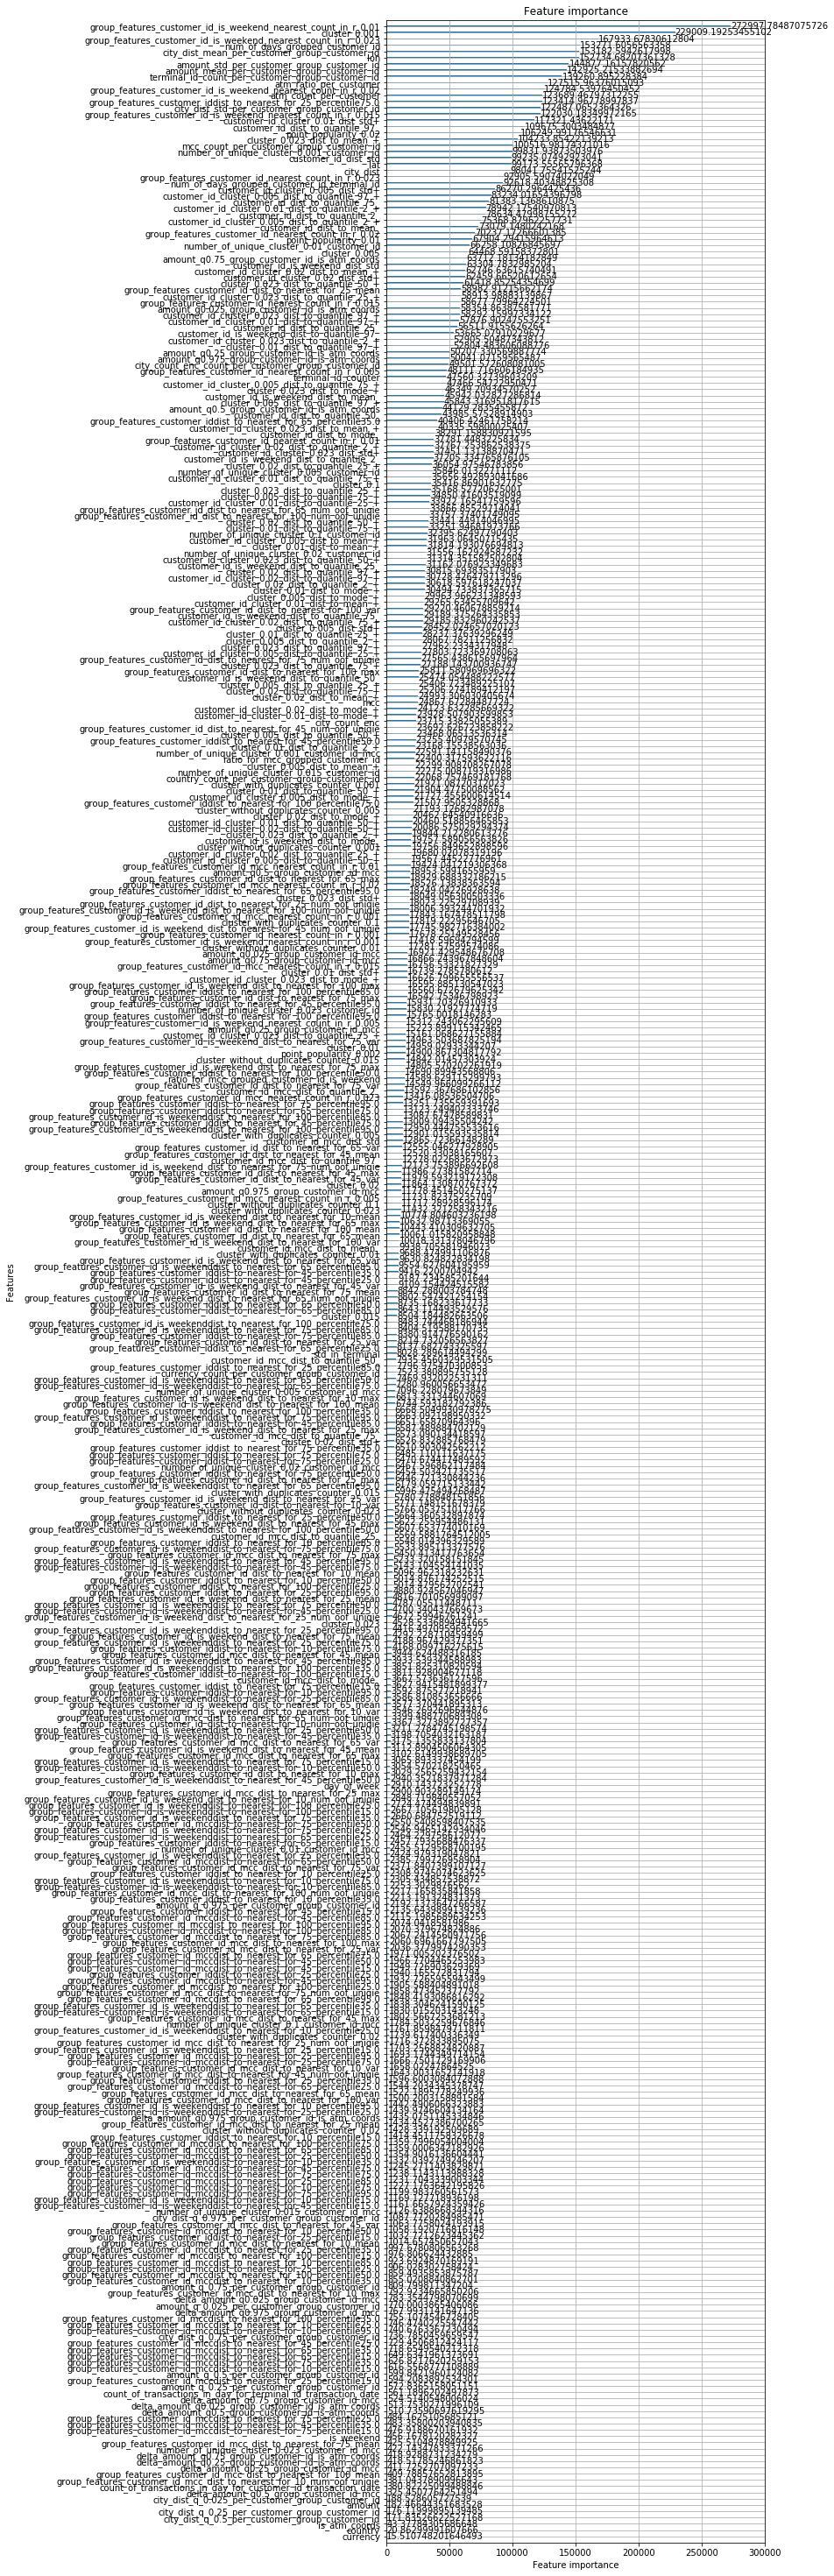

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 50))
ax = fig.add_axes([0.1, 0.4, 0.6, 0.8])
lgb.plot_importance(gbm, ax, importance_type='gain', max_num_features=-1)

##### home

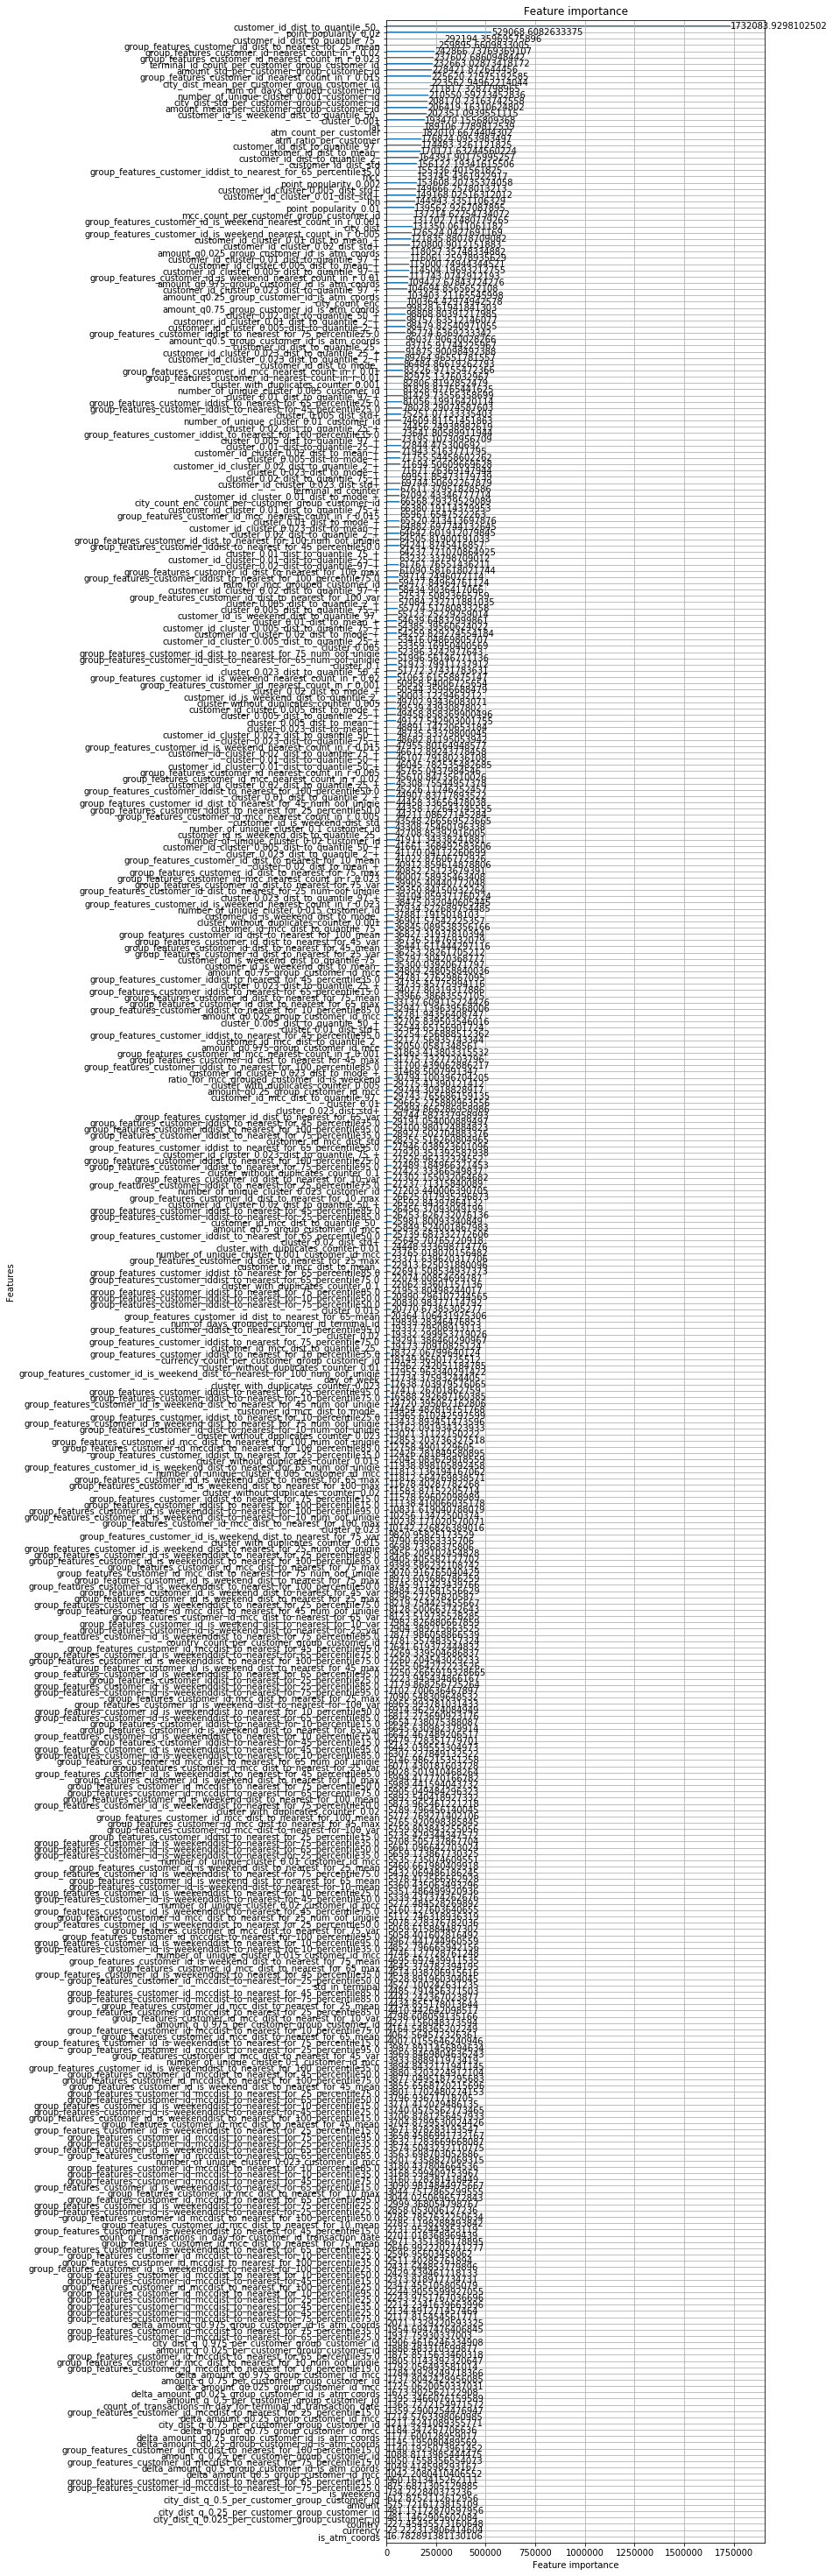

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 50))
ax = fig.add_axes([0.1, 0.4, 0.6, 0.8])
lgb.plot_importance(gbm, ax, importance_type='gain', max_num_features=-1)

##### local validation

In [ ]:
NUM_OF_TREES = [700, 250]

In [ ]:
%%time 

cv = LabelShuffleSplit(dt_tr['customer_id'].values, n_iter=1, 
                       test_size=0.2, random_state=1)

score = []
for train_idx, test_idx in cv:
    pass

target = ['is_home', 'is_work']
preds = pd.DataFrame()


for i in [0,1]:
    
    X_tr, X_ts = dt_tr.iloc[train_idx], dt_tr.iloc[test_idx]
    y_tr = X_tr[target[i]]
    
    X_tr = X_tr.drop(['customer_id', 'is_home', 'is_work'], axis=1)

    X_ts = X_ts.drop(['customer_id', 'is_home', 'is_work'], axis=1)
    
    lgb_train = lgb.Dataset(X_tr.values, y_tr.values, feature_name=list(X_tr.columns.values))
    print('Start training...')
    gbm = lgb.train(params, lgb_train, num_boost_round=NUM_OF_TREES[i])
    print('Start predicting...')
    preds[target[i]] = gbm.predict(X_ts)
    
    
tmp = dt_tr.iloc[test_idx].reset_index()

coords = tmp[['lat', 'lon']]
coords['prob'] = 0
coords['customer_id'] = tmp.customer_id

coords['prob_is_home'] = preds.is_home
coords['prob_is_work'] = preds.is_work

coords['home_ans'] = 0
idx = coords.groupby('customer_id')['prob_is_home'].apply(np.argmax).reset_index()['prob_is_home']
coords.loc[idx, 'home_ans'] = 1

coords['work_ans'] = 0
idx = coords.groupby('customer_id')['prob_is_work'].apply(np.argmax).reset_index()['prob_is_work']
coords.loc[idx, 'work_ans'] = 1

work_ans = coords[coords['work_ans'] == 1][['lat', 'lon', 'customer_id']]
home_ans = coords[coords['home_ans'] == 1][['lat', 'lon', 'customer_id']]
final_ans = pd.merge(work_ans, home_ans, on='customer_id', suffixes=('_work', '_home'))
final_ans = final_ans[['customer_id', 'lat_work', 'lon_work', 'lat_home', 'lon_home']]

res = pd.merge(final_ans, a, on='customer_id')
work_coincides = np.sqrt((res.lat_work - res.work_add_lat)**2 + (res.lon_work - res.work_add_lon)**2) <= 0.02
home_coincides = np.sqrt((res.lat_home - res.home_add_lat)**2 + (res.lon_home - res.home_add_lon)**2) <= 0.02

In [ ]:
np.mean(work_coincides), np.mean(home_coincides)

In [ ]:
print(np.mean(work_coincides), np.mean(home_coincides))

In [ ]:
import telepot
bot = telepot.Bot('364673976:AAFZPVl8gEPFxZPczfiHDV_FmBCGQdL7_q8')
bot.sendMessage(139633784, 'done \n {} {}'.format(np.mean(work_coincides), np.mean(home_coincides)));

#### Pred

In [ ]:
NUM_OF_TREES = [800, 330]

In [ ]:
preds = pd.DataFrame()

for i in [0,1]:
    
    X_tr, X_ts = dt_tr.copy(), dt_ts.copy()
    y_tr = X_tr[target[i]]
    
    X_tr = X_tr.drop(['customer_id', 'is_home', 'is_work'], axis=1)

    X_ts = X_ts.drop(['customer_id', 'is_home', 'is_work'], axis=1)
    
    lgb_train = lgb.Dataset(X_tr.values, y_tr.values, feature_name=list(X_tr.columns.values))
    print('Start training...')
    gbm = lgb.train(params, lgb_train, num_boost_round=NUM_OF_TREES[i])
    preds[target[i]] = gbm.predict(X_ts)

In [ ]:
coords = dt_ts[['lat', 'lon']]

coords['customer_id'] = dt_ts.customer_id

coords['prob'] = 0

coords['prob_is_home'] = preds.is_home
coords['prob_is_work'] = preds.is_work

coords['home_ans'] = 0
idx = coords.groupby('customer_id')['prob_is_home'].apply(np.argmax).reset_index()['prob_is_home']
coords.loc[idx, 'home_ans'] = 1

coords['work_ans'] = 0
idx = coords.groupby('customer_id')['prob_is_work'].apply(np.argmax).reset_index()['prob_is_work']
coords.loc[idx, 'work_ans'] = 1

In [ ]:
work_ans = coords[coords['work_ans'] == 1][['lat', 'lon', 'customer_id']]

home_ans = coords[coords['home_ans'] == 1][['lat', 'lon', 'customer_id']]

final_ans = pd.merge(work_ans, home_ans, on='customer_id', suffixes=('_work', '_home'))

final_ans = final_ans[['customer_id', 'lat_work', 'lon_work', 'lat_home', 'lon_home']]

In [ ]:
final_ans.tail()

In [ ]:
final_ans.shape

In [ ]:
final_ans.to_csv('amir_.csv', index=None)

In [ ]:
!head amir_.csv

In [ ]:
import numpy as np
import pandas as pd

subm = pd.read_csv('amir_.csv')

def test_subm(subm):
    assert len(subm.customer_id.unique()) == 9997, 'потеряли клиента или их больше положенного'
    assert np.any(subm.customer_id.duplicated()) == False, 'одному клиенту соответствует больше одной записи'
    assert len(subm[np.sum(subm.isnull(), axis=1) != 0]) == 0, 'в файлике наны'
    for col_name in subm.columns:
        assert subm[col_name].isnull().sum() == 0, u'В колонке {col_name} есть NULL'.format(col_name=col_name)
    print('все ок')

test_subm(subm)

In [2]:
import numpy as np
import pandas as pd

subm = pd.read_csv('amir_.csv')

In [4]:
subm['lat_home'] = 0
subm['lon_home'] = 0

In [5]:
subm.to_csv('amir_w.csv', index=None)